In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#train data
train = pd.read_csv('../data/train.csv')
train.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [4]:
#test data
test = pd.read_csv('../data/test data.csv')
test.head()

,Date,store,product,number_sold
0,2019-01-01,0,0,845
1,2019-01-02,0,0,851
2,2019-01-03,0,0,840
3,2019-01-04,0,0,842
4,2019-01-05,0,0,845


In [5]:
test.tail()

,Date,store,product,number_sold
25545,2019-12-27,6,9,901
25546,2019-12-28,6,9,926
25547,2019-12-29,6,9,913
25548,2019-12-30,6,9,899
25549,2019-12-31,6,9,886


### Time series for Product 0 in Store 0

Preprocessing

In [6]:
#create a new training df which only consist of product 0 in store 0
trDf = train.loc[(train['product']==0) & (train['store']==0)].copy()
trDf.drop(columns=['product','store'], inplace=True)
trDf['Date'] = pd.to_datetime(trDf['Date'])
trDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3287 entries, 0 to 3286
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         3287 non-null   datetime64[ns]
 1   number_sold  3287 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 77.0 KB


In [7]:
trDf.set_index('Date', inplace=True)
trDf.head()

,number_sold
Date,
2010-01-01,801
2010-01-02,810
2010-01-03,818
2010-01-04,796
2010-01-05,808


In [8]:
#creating a new test df which only consist of product 0 in store 0
tsDf = test.loc[(test['product']==0) & (test['store']==0)].copy()
tsDf.drop(columns=['product', 'store'], inplace=True)
tsDf['Date'] = pd.to_datetime(tsDf['Date'])
tsDf.set_index('Date', inplace=True)
tsDf.head()

,number_sold
Date,
2019-01-01,845
2019-01-02,851
2019-01-03,840
2019-01-04,842
2019-01-05,845


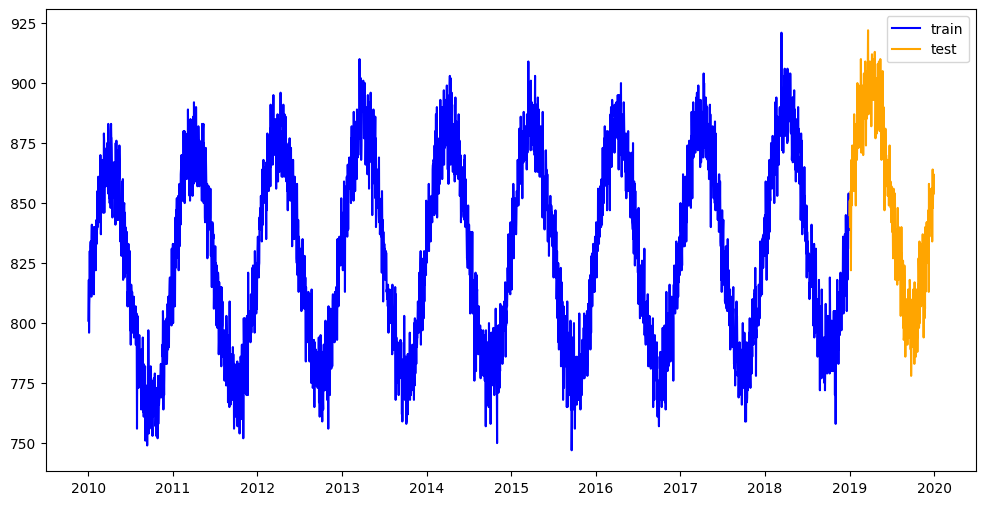

In [9]:
plt.figure(figsize=(12,6))
plt.plot(trDf, color='blue', label='train')
plt.plot(tsDf, color='orange', label='test')
plt.legend()
plt.show()

Assessing Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

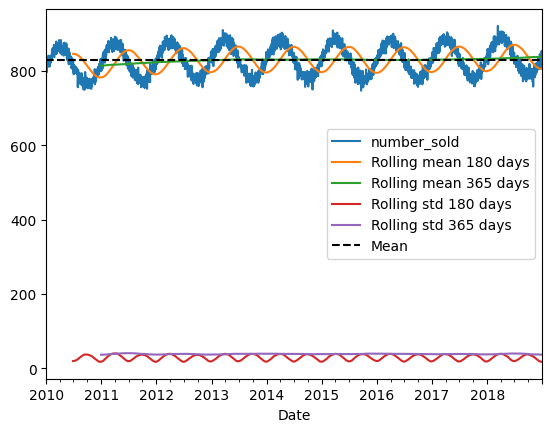

In [11]:
trDf['number_sold'].plot()
trDf['number_sold'].rolling(180).mean().plot(label='Rolling mean 180 days')
trDf['number_sold'].rolling(365).mean().plot(label='Rolling mean 365 days')
trDf['number_sold'].rolling(180).std().plot(label='Rolling std 180 days')
trDf['number_sold'].rolling(365).std().plot(label='Rolling std 365 days')
plt.axhline(trDf['number_sold'].mean(), linestyle='--', color='black', label='Mean')
plt.legend()
plt.show()

In [12]:
result = adfuller(trDf['number_sold'])

print('ADF Statistic:', result[0])
print('p-value', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: -5.051464907455929
p-value 1.7536429088010992e-05
Critical Values: {'1%': -3.4323593525669414, '5%': -2.8624278120183573, '10%': -2.567242601304915}
The time series is stationary.


We don't have a unit root but our data is not yet stationary as it still has seasonality

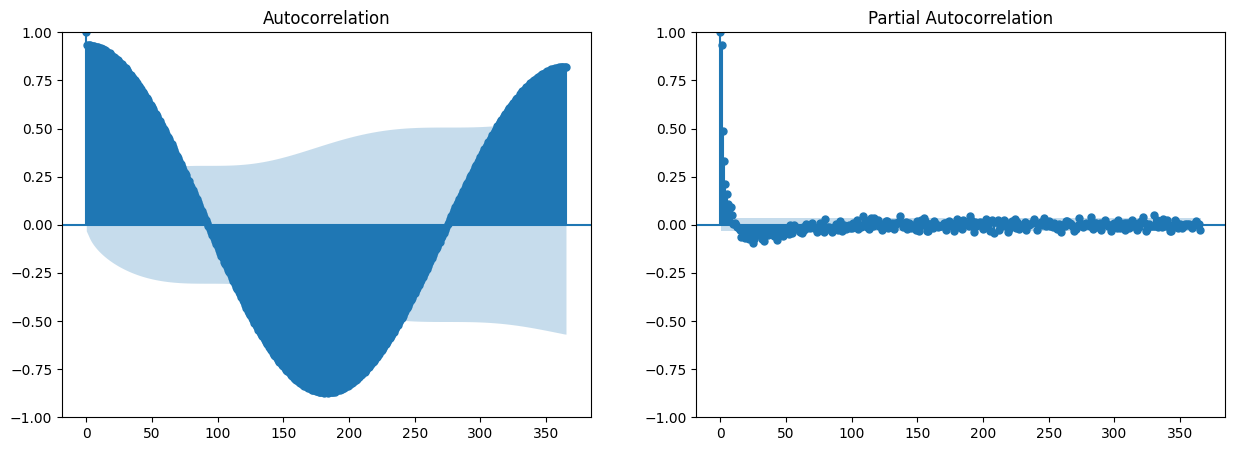

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
plot_acf(trDf['number_sold'], lags=365, ax=axes[0])
plot_pacf(trDf['number_sold'], lags=365, ax=axes[1])
plt.show()

To further confirm seasonality, let us plot a seasonal decomposition graph

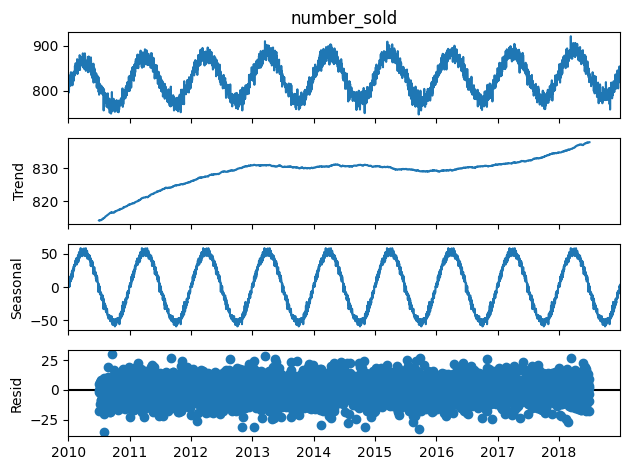

In [14]:
decomp = seasonal_decompose(trDf['number_sold'], model='additive', period=365)
decomp.plot()
plt.show()

Implementing Solution

It is confirmed that our data is seasonal. Let us solve it by using seasonality differencing

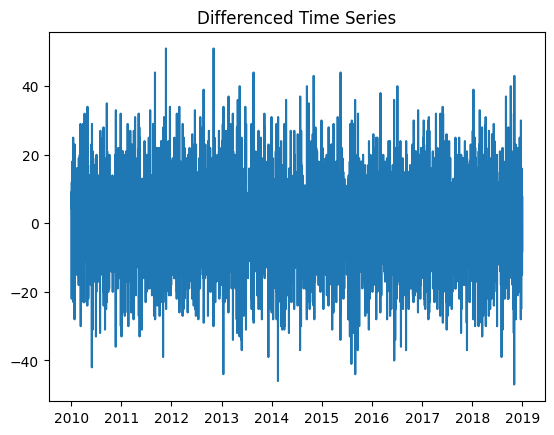

In [15]:
trDf['diff'] = trDf['number_sold'].diff()
trDf.dropna(inplace=True)
plt.plot(trDf['diff'])
plt.title('Differenced Time Series')
plt.show()

In [16]:
result = adfuller(trDf['diff'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.604247851143501
p-value: 1.2446461152859596e-06


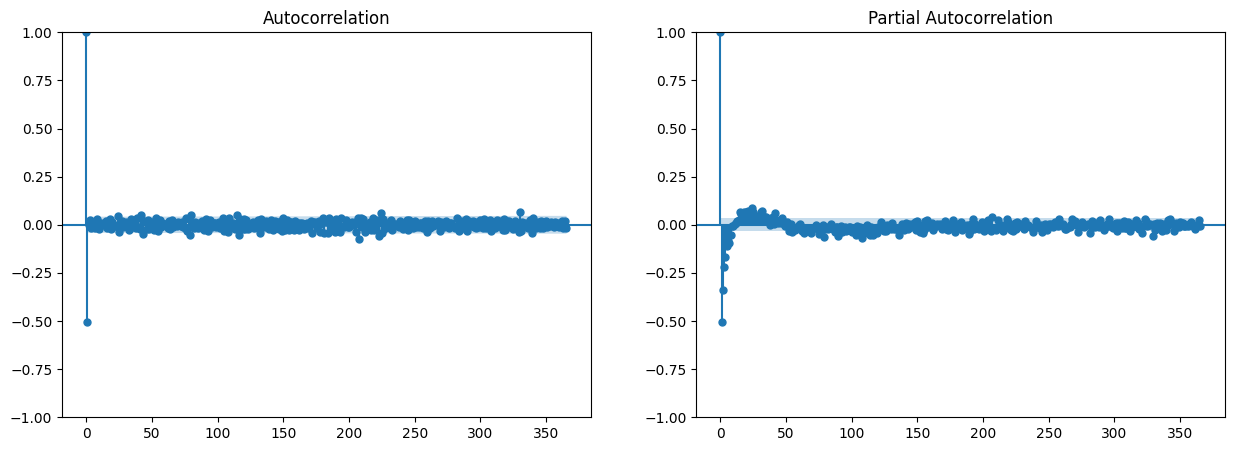

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
plot_acf(trDf['diff'], lags=365, ax=axes[0])
plot_pacf(trDf['diff'], lags=365, ax=axes[1])
plt.show()

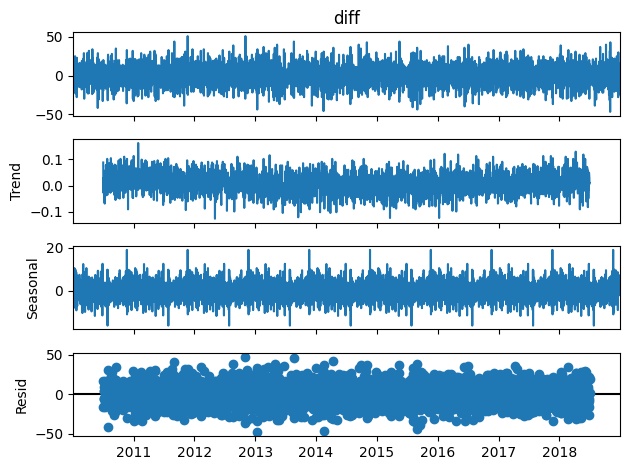

In [18]:
decomp = seasonal_decompose(trDf['diff'], model='additive', period=365)
decomp.plot()
plt.show()

AutoRegressive Model

In [19]:
from statsmodels.tsa.ar_model import AutoReg

In [20]:
ar_model = AutoReg(trDf['number_sold'], lags=365)
ar = ar_model.fit()
ar.summary()

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            number_sold   No. Observations:                 3286
Model:                   AutoReg(365)   Log Likelihood              -10675.663
Method:               Conditional MLE   S.D. of innovations              9.355
Date:                Fri, 13 Feb 2026   AIC                          22085.326
Time:                        17:19:19   BIC                          24279.869
Sample:                    01-02-2011   HQIC                         22875.769
                         - 12-31-2018                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               90.9126     35.193      2.583      0.010      21.935     159.890
number_sold.L1       0.0092      0.018      0.496      0.620      -0.027       0.045
number_sold.L2       0.0356      0.018      1.925      0.054      -0.001       0.072
number_sold.L3       0.0499      0.018      2.697      0.007       0.014       0.086
number_sold.L4       0.0326      0.019      1.761      0.078      -0.004       0.069
number_sold.L5       0.0316      0.019      1.707      0.088      -0.005       0.068
number_sold.L6      -0.0068      0.019     -0.366      0.715      -0.043       0.030
number_sold.L7      -0.0103      0.019     -0.556      0.578      -0.047       0.026
number_sold.L8       0.0273      0.019      1.476      0.140      -0.009       0.064
number_sold.L9       0.0066      0.019      0.356      0.722      -0.030       0.043
number_sold.L10     -0.0091      0.019     -0.488      0.625      -0.045       0.027
number_sold.L11      0.0067      0.019      0.359      0.720      -0.030       0.043
number_sold.L12      0.0031      0.019      0.165      0.869      -0.033       0.039
number_sold.L13      0.0291      0.019      1.565      0.118      -0.007       0.065
number_sold.L14      0.0383      0.019      2.061      0.039       0.002       0.075
number_sold.L15      0.0150      0.019      0.804      0.421      -0.021       0.051
number_sold.L16     -0.0101      0.019     -0.542      0.588      -0.047       0.026
number_sold.L17      0.0101      0.019      0.541      0.589      -0.026       0.047
number_sold.L18      0.0444      0.019      2.387      0.017       0.008       0.081
number_sold.L19      0.0062      0.019      0.333      0.739      -0.030       0.043
number_sold.L20      0.0233      0.019      1.255      0.210      -0.013       0.060
number_sold.L21     -0.0054      0.019     -0.290      0.772      -0.042       0.031
number_sold.L22      0.0083      0.019      0.443      0.657      -0.028       0.045
number_sold.L23      0.0200      0.019      1.073      0.283      -0.016       0.056
number_sold.L24      0.0330      0.019      1.776      0.076      -0.003       0.069
number_sold.L25     -0.0038      0.019     -0.206      0.837      -0.040       0.033
number_sold.L26     -0.0174      0.019     -0.938      0.348      -0.054       0.019
number_sold.L27     -0.0048      0.019     -0.261      0.794      -0.041       0.032
number_sold.L28     -0.0012      0.019     -0.063      0.950      -0.038       0.035
number_sold.L29      0.0375      0.019      2.019      0.043       0.001       0.074
number_sold.L30      0.0426      0.019      2.293      0.022       0.006       0.079
number_sold.L31      0.0419      0.019      2.249      0.025       0.005       0.078
number_sold.L32      0.0134      0.019      0.718      0.472      -0.023       0.050
number_sold.L33     -0.0281      0.019     -1.508      0.132      -0.065       0.008
number_sold.L34      0.0298      0.019      1.602      0.109      -0.007       0.066
number_sold

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


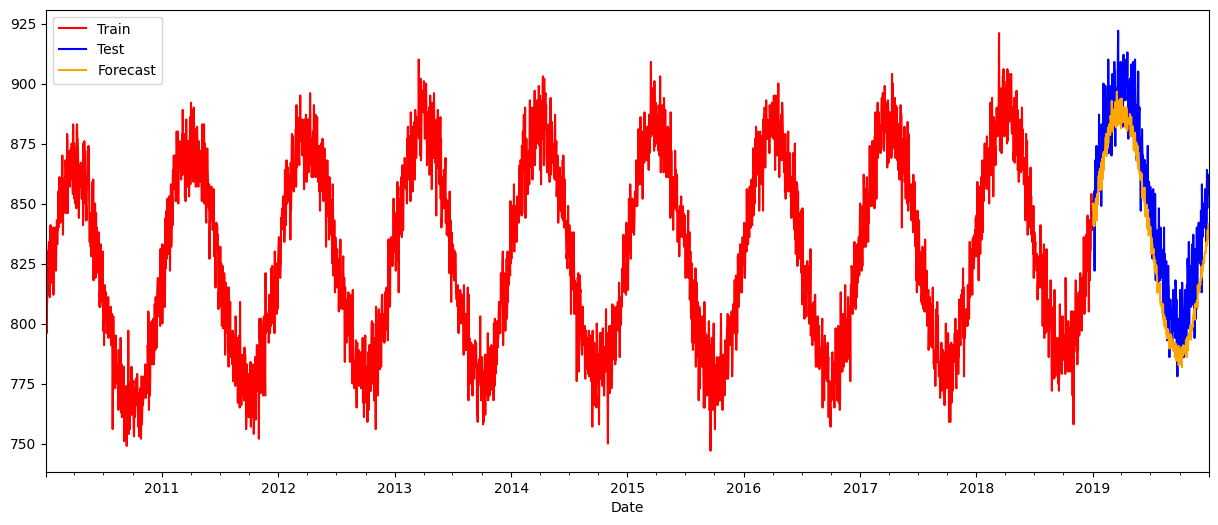

In [26]:
forecast = ar.predict(start=len(trDf), end=len(trDf)+len(tsDf)-1)
plt.figure(figsize=(15,6))
trDf['number_sold'].plot(label='Train', color='red')
tsDf['number_sold'].plot(label='Test', color='blue')
forecast.plot(label='Forecast', color='orange')
plt.legend()
plt.show()

In [22]:
forecast

2019-01-01    849.779262
2019-01-02    850.088560
2019-01-03    844.772611
2019-01-04    840.674188
2019-01-05    844.360049
                 ...    
2019-12-27    833.478233
2019-12-28    838.831947
2019-12-29    835.517533
2019-12-30    838.128662
2019-12-31    841.508156
Freq: D, Length: 365, dtype: float64

In [23]:
#convert forecast to df
forecast_data = forecast.reset_index()
forecast_data.columns = ['Date', 'no_sold']
forecast_data

,Date,no_sold
0,2019-01-01,849.779262
1,2019-01-02,850.088560
2,2019-01-03,844.772611
3,2019-01-04,840.674188
4,2019-01-05,844.360049
...,...,...
360,2019-12-27,833.478233
361,2019-12-28,838.831947
362,2019-12-29,835.517533
363,2019-12-30,838.128662


## Evaluation 

In [24]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

In [25]:
print('RMSE:', rmse(tsDf['number_sold'], forecast))
print('MAPE:', mean_absolute_percentage_error(tsDf['number_sold'], forecast))

RMSE: 16.52780991856141
MAPE: 0.016443230756490984
